# Trip Generation

This notebook (prepared by Gaurav) is supposed to be a part of a bigger excercise that takes us sequentially through various steps involved in the traditional demand modelling. By this time, we would have already defined our network i.e. nodes (including centroids) and links (along with link attributes). At this stage, we are already capable of ascertaining which path (or links) will the driver likely use if he/she needs to go from a particular origin to a particular destination i.e. shortest path calculation. What we need to predict ultimately in a demand model is how many drivers there will be on each link of the network. It's quite logical to see that the missing gap between our current capability and the desired capability is the capability to predict how many drivers would want to undertake a trip in between each of the OD pairs. This missing gap is filled in two steps. In the first step, we find out how many trips are produced i.e. have their origins at each centroid (zone) and how many trips are attracted i.e. have their destination at each centroid (zone). Then in the 2nd step, we try to find the destinations of the trips whose origin we know and origins of the trips whose destination we know in order to have our full OD matrix. It's the first of these two steps that we will focus on in this notebook.

**NB**: After these two steps i.e. after having our OD matrix, we can realise our ultimate goal of predicting link flows by performing a traffic assignment step which is analogous to carrying out shortest path calculation (though not always the same - think about stochastic choices and congestible links).

In [124]:
# Import packages
import numpy as np
import networkx as nx
from stapy.network_data import *
from stapy.visualization import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from bokeh.layouts import row
import pandas as pd
import geopandas as gpd
import pickle

### Adding zonal data

So, the first step in predicting how many trips a zone may attract or produce is to ascertain which kind of variables may influence them e.g. if a zone has a lot of offices or a lot shops then it is expected to attract a lot of trips; however, if it's a residential area, then the no. of trips produced will most likely outweigh the no. of trips attracted. 

**NB:** Trips from a certain place e.g. office/shop to home are still considered to be produced by home and not by the office/shop. This is because otherwise there would be no difference between production and attraction as everyone will eventually return to home. However, this is as an exception only for home based trips. **PAUL PLEASE CONFIRM?** e.g. A trip starting from shop A to shop B is considerd to be produced by shop A (and attracted by shop B) but a trip from shop A back to home is considered to be produced by home. 

In this notebook, we will consider the following variables to affect productions and attractions for a zone.

1. Number of households
2. Average household size
3. Average number of driving license holders per household
4. Average household income (in units of 1.000 euros)
5. Office space (in units of 1.000 m2)
6. Retail space (in units of 1.000 m2)

You may think of some other factors that influence trip production or attraction and use them in the prediction provided you have enough measurements both for calibration (parameter estimation) and validation of the prediction model.

In [125]:
# Import excel data from data folder
zonal_data = 'data/Zonal_Data.xls'
household_data = 'data/Household_Observations.xls'

In [126]:
df_zone = pd.read_excel(zonal_data, skiprows=np.arange(0,11, 1),
                        usecols=['Zone:', 'HOUSEHOLDS', 'HOUSEHOLDSIZE','LICENSEHOLDERS', 'INCOME', 'OFFICESPACE'
                                ,'RETAILSPACE'])
df_zone.head()

,Zone:,HOUSEHOLDS,HOUSEHOLDSIZE,LICENSEHOLDERS,INCOME,OFFICESPACE,RETAILSPACE
0,1,1250.0,1.90,1.20,25.0,20.0,10.0
1,2,800.0,1.70,1.05,27.0,25.0,5.0
2,3,900.0,2.00,1.00,26.0,75.0,15.0
3,4,1500.0,1.85,1.15,23.0,300.0,90.0
4,5,300.0,1.80,1.20,25.0,80.0,45.0


As you see some extra parameters were passed. Inspecting the excel file and passing the right parameter values will make it easier to immediately have a good dataframe, instead of having to perform extra operations to filter out the needed data.

In [127]:
# Running this block of code multiple times will always remove the two last rows of the dataframe
df_zone.rename(columns={'Zone:':'zone'}, inplace=True)
df_zone.drop(df_zone.tail(2).index, axis=0, inplace=True)
df_zone

,zone,HOUSEHOLDS,HOUSEHOLDSIZE,LICENSEHOLDERS,INCOME,OFFICESPACE,RETAILSPACE
0,1,1250.0,1.90,1.20,25.0,20.0,10.0
1,2,800.0,1.70,1.05,27.0,25.0,5.0
2,3,900.0,2.00,1.00,26.0,75.0,15.0
3,4,1500.0,1.85,1.15,23.0,300.0,90.0
4,5,300.0,1.80,1.20,25.0,80.0,45.0
5,6,750.0,1.95,1.10,30.0,115.0,35.0
6,7,500.0,2.00,1.20,31.0,60.0,10.0
7,8,400.0,2.00,1.10,33.0,45.0,20.0
8,9,100.0,2.10,1.30,35.0,10.0,5.0


In [128]:
df_hh = pd.read_excel(household_data)
df_hh.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,HOUSEHOLD OBSERVATIONS,NaN,NaN,NaN,NaN
1,NaN,Number of trips per household (T),NaN,NaN,NaN,NaN
2,NaN,Household size (S),NaN,NaN,NaN,NaN
3,NaN,Number of drivers license holders (L),NaN,NaN,NaN,NaN
4,NaN,Household income (I),NaN,NaN,NaN,NaN


**Qc:** Read out the needed information of the excel file for the households data such that the output is ready for use

In [129]:
# Do the needed operations here
df_hh = pd.read_excel(household_data, skiprows=np.arange(0,8, 1),
                        usecols=['Observations:', 'T', 'S','L', 'I'])
df_hh.head()

,Observations:,T,S,L,I
0,1,7,2,1,20
1,2,5,1,1,30
2,3,4,1,1,10
3,4,5,2,1,20
4,5,9,4,2,30


We now have our given datasources in the right format to do further operations and use it in our constructed graph of the previous notebook. Next step is to import the graph and constructed zones of the previous notebook to link the data to the right zone.

In [130]:
with open('graph', 'rb') as a:
    gr = pickle.load(a)
with open('zones', 'rb') as a:
    zones = pickle.load(a)

In [131]:
df_zone.zone = zones.zone
zones_wd = zones.merge(df_zone, how='left', on='zone') 
zones_wd.head()

,zone,id,centroid,x,y,geometry,HOUSEHOLDS,HOUSEHOLDSIZE,LICENSEHOLDERS,INCOME,OFFICESPACE,RETAILSPACE
0,1,c1,"[0.75, 0.5]",0.75,0.5,"POLYGON ((1.50000 0.00000, 1.50000 1.00000, 0....",1250.0,1.90,1.20,25.0,20.0,10.0
1,2,c2,"[0.75, 1.5]",0.75,1.5,"POLYGON ((1.50000 1.00000, 1.50000 2.00000, 0....",800.0,1.70,1.05,27.0,25.0,5.0
2,3,c3,"[0.75, 2.5]",0.75,2.5,"POLYGON ((1.50000 2.00000, 1.50000 3.00000, 0....",900.0,2.00,1.00,26.0,75.0,15.0
3,4,c4,"[2.25, 0.5]",2.25,0.5,"POLYGON ((3.00000 0.00000, 3.00000 1.00000, 1....",1500.0,1.85,1.15,23.0,300.0,90.0
4,5,c5,"[2.25, 1.5]",2.25,1.5,"POLYGON ((3.00000 1.00000, 3.00000 2.00000, 1....",300.0,1.80,1.20,25.0,80.0,45.0


In [132]:
hovertips = [('zone','@zone'),('households','@HOUSEHOLDS'),('license','@LICENSEHOLDERS'),('income','@INCOME')]
poly_plot = show_polygons(zones_wd, hovertips=hovertips, colorbar=(True, 'OFFICESPACE', '# OFS'),
              notebook=True, show_plot=False, add_cm_legend=True)
plot_network(gr, notebook=True,figure_obj=poly_plot,show_plot=True, mode='theoretical', scaling=0.03)

Figure(id='3075', ...)

- **Qc:** Visualize another attribute

Since all the data is in the same dataframe it is easy to visualize it. The previous plot can easily visualize how one attribute value differs for every zone but not for more at the same time. The advantage of using the dataframe format is that visualization of the columns is very easily done.

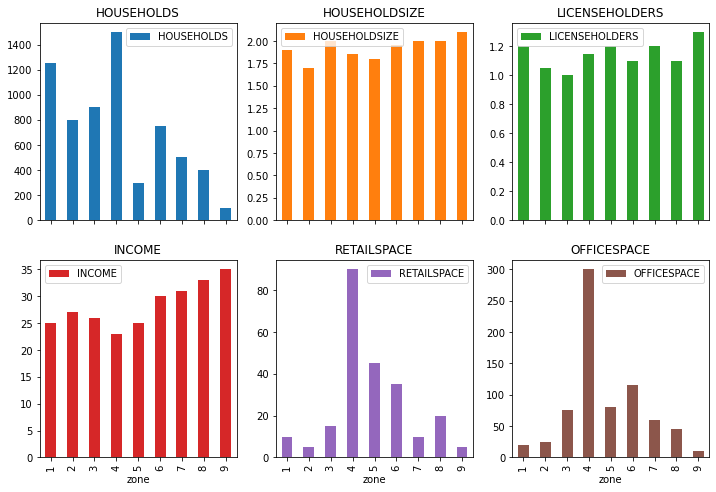

In [133]:
# Plot function of pandas has more options than geopandas --> quick conversion to visualize data
zones_pd = pd.DataFrame(zones_wd)
plot_variables = zones_pd.plot('zone',y=['HOUSEHOLDS', 'HOUSEHOLDSIZE', 'LICENSEHOLDERS',
                                         'INCOME','RETAILSPACE', 'OFFICESPACE'],
                               kind='bar', subplots=True, sharex=True, layout=(2,3))

### Computing productions and attractions

In order to determine the trip productions and attractions, we use a linear regression model.

For the trip attractions $A_j$, a regression model has already been estimated and is given by the following equation:
\begin{align}
A_{J}& = 52.5 \times O{j} + 15.8 \times R_{j}&(1) \\
\end{align}                                                                                               

where $O_j$ is the amount of office space (in units of 1.000 m2) in zone j and $R_j$ is the amount of retail space (in units of 1.000 m2) in zone j.

- **Q:** *The regression model for attraction doesn't take into account any of the characteristics of the households. Why is that? Can such a model give good predictions?*
*The answer lies in our introductory discussion of this section.*

For the trip productions $P_i$ is determined by $P_i = H_i \times T_i$ where $H_i$ is the number of households in zone i and $T_i$ is the average number of trips a household makes in zone i. This average number of trips will be determined by the following linear regression model:

\begin{align}
T_{i}& = \beta_1 \times S{i} + \beta_2 \times L_{i} + \beta_3 \times I_{i}&(2) \\
\end{align}  
                                                                                                   
where $S_i$ is the average household size, $L_i$ is the average number of driver’s license holders in a household, and $I_i$ is the average household income (in units of 1000 euro’s). 
The parameters $\beta_1, \beta_2$ and $\beta_3$ have to be estimated using the household data ( $S_i$, $L_i$ & $I_i$ ) that has already been presented.

Before we move on to the estimation of these parameters, let's talk a bit about the model $P_i = H_i \times T_i$. This model, inherently, assumes that the no. of trip productions are not influenced by the presence of anything other than houses (e.g. shops and offices). 
- **Q:** How good is this assumption? Try to think **beyond** our introductory discussion of this section.

*The answer actually depends on our study interests. If we are talking about inter-city networks with bigger zones, **may be** it's a good enough assumption but it can be erroneous if we are working at a more detailed level with very small sized zones. Hint: Think about what happens to the bike traffic during lunch/dinner hours if our study area is Leuven and our zones are small parts inside the ring. Further hint: Think about delivery services in general.* 

Coming back to **parameter estimation**, we will use a least squares minimisation of the errors (minimisation of $E^TE$). We will represent the eq. 2 in the form $A\beta = T$, where A will form the input matrix now including the input data $S_i$, $L_i$ & $I_i$ in each row and T will be the output matrix. Then, $\beta = pseudoinv(A) \times T$ gives us our estimation of the three parameters.   



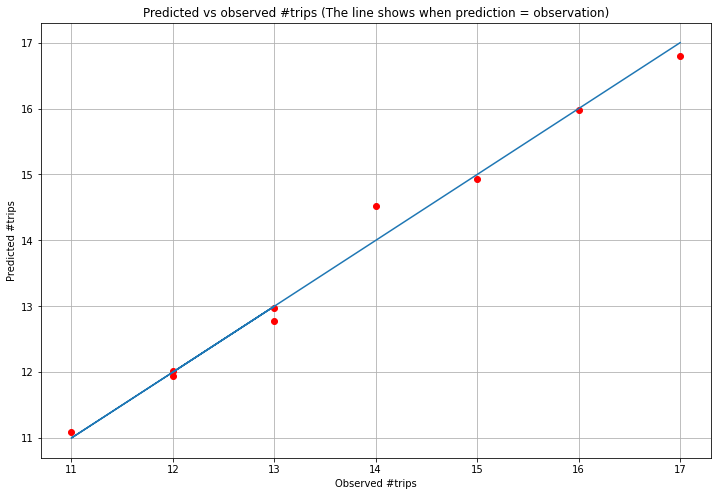

In [134]:
A = zones_wd[['HOUSEHOLDSIZE', 'LICENSEHOLDERS','INCOME']].values
T = np.transpose([[12,13,13,11,12,14,15,16,17]]) 
# These are our observations of average trips/household per zone 
# i.e. 9 observations. Disclaimer: These are totally fictitious.
beta = np.linalg.lstsq(A,T,rcond=None)[0]
#Predicted Trips
T_p = A@beta; # Matrix multiply, in numpy the product is element wise by default


plt.plot(T,T_p,'or', T,T)
plt.xlabel('Observed #trips')
plt.ylabel('Predicted #trips')
plt.title('Predicted vs observed #trips (The line shows when prediction = observation)')
plt.grid()

- **Q:** Can you already think of a problem with this kind of parameter estimation and then using these parameters for prediction of trips/household per zone? 
- **Q:** What are the conditions that can make such an estimation a good choice and when will such a model give absurd results?

Think for some minutes! Think about the differences in behaviour of different zones! Think for a minute before reading further!

If you can't think of something (and even otherwise), it is a very good moment to check out what 'ecological correlation' means from course notes. 
We used zonal averages to estimate our model. From figure 5.1 in the course notes, it is quite logical to see that such a prediction can easily become absurd if our zones don't behave similar to each other. Note that the zones can have different characteristics (means) and in fact that's the point of dividing the study area into zones but we have a problem in using zonal averages for parameter estimation if these zones have different **sensitivities**.

- **Q:** Think about what it means for a moment.

So what should we do instead??

We should always try to use disaggregate data (of course it's not always available) i.e. data recorded from individual households and instead of using zonal averages. Now, we will perform another estimation based on this disaggregate data collected from 36 random households. It would be better if we can estimate a set of parameters per zone but even when we have to use a single set of parameters for all zones it is better this way than using zonal averages. 

- **Qc:** Perform this linear regression for parameter estimation in the block below

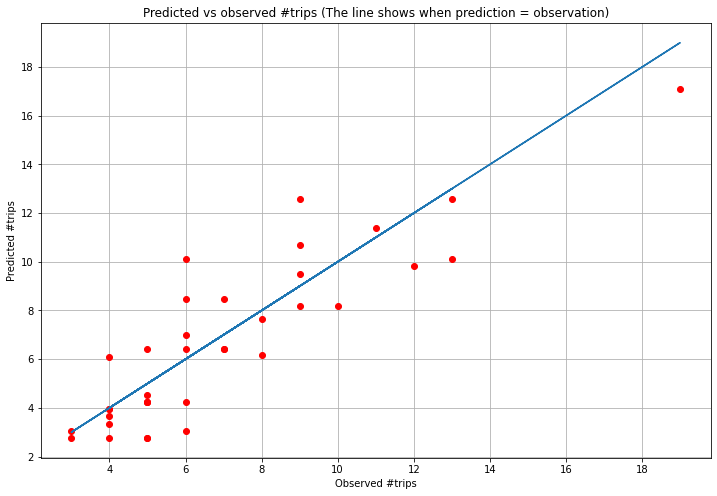

In [135]:
# Do operations here
# Disaggregate observations
Ad = df_hh[['S','L','I']].values
Td = df_hh['T'].values
betad = np.linalg.lstsq(Ad,Td,rcond=None)[0]
T_pd = Ad@betad; # predicted disaggregate trips

plt.plot(Td,T_pd,'or',Td,Td)
plt.xlabel('Observed #trips')
plt.ylabel('Predicted #trips')
plt.title('Predicted vs observed #trips (The line shows when prediction = observation)')
plt.grid()

In [136]:
zones_wd = zones_wd.assign(THH_est = A@betad)
zones_wd.head()
# Now we compute the zonal trips/household using the parameters estimated from the household data.

,zone,id,centroid,x,y,geometry,HOUSEHOLDS,HOUSEHOLDSIZE,LICENSEHOLDERS,INCOME,OFFICESPACE,RETAILSPACE,THH_est
0,1,c1,"[0.75, 0.5]",0.75,0.5,"POLYGON ((1.50000 0.00000, 1.50000 1.00000, 0....",1250.0,1.90,1.20,25.0,20.0,10.0,6.513056
1,2,c2,"[0.75, 1.5]",0.75,1.5,"POLYGON ((1.50000 1.00000, 1.50000 2.00000, 0....",800.0,1.70,1.05,27.0,25.0,5.0,5.935909
2,3,c3,"[0.75, 2.5]",0.75,2.5,"POLYGON ((1.50000 2.00000, 1.50000 3.00000, 0....",900.0,2.00,1.00,26.0,75.0,15.0,6.605822
3,4,c4,"[2.25, 0.5]",2.25,0.5,"POLYGON ((3.00000 0.00000, 3.00000 1.00000, 1....",1500.0,1.85,1.15,23.0,300.0,90.0,6.287068
4,5,c5,"[2.25, 1.5]",2.25,1.5,"POLYGON ((3.00000 1.00000, 3.00000 2.00000, 1....",300.0,1.80,1.20,25.0,80.0,45.0,6.265113


**NB:** *The data is completely fictitious and the zonal averages are not consistent with the disaggregate data i.e. household data. So don't try to compare this trip prediction with the earlier prediction (or the actual data) in order to make any conclusions.*

In [137]:
#Calculating production and attraction
zones_wd = zones_wd.assign(P=zones_wd.HOUSEHOLDS*zones_wd.THH_est)
zones_wd = zones_wd.assign(A=52.5*zones_wd.OFFICESPACE + 15.8*zones_wd.RETAILSPACE)
zones_wd[['zone','THH_est', 'HOUSEHOLDS', 'P', 'A']].head()

,zone,THH_est,HOUSEHOLDS,P,A
0,1,6.513056,1250.0,8141.320294,1208.0
1,2,5.935909,800.0,4748.726962,1391.5
2,3,6.605822,900.0,5945.239563,4174.5
3,4,6.287068,1500.0,9430.601852,17172.0
4,5,6.265113,300.0,1879.533781,4911.0


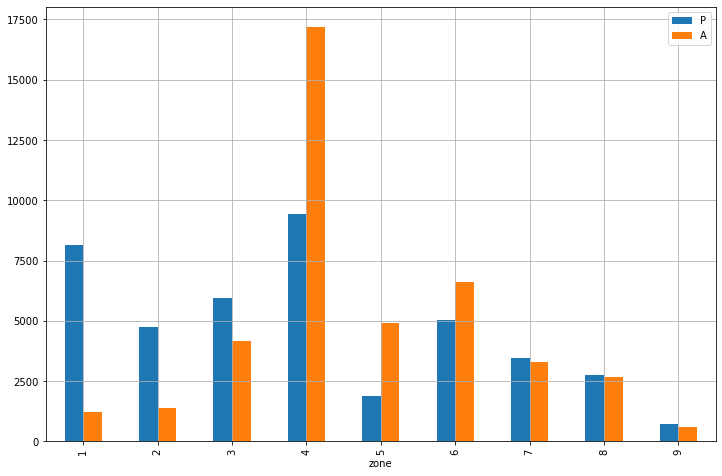

In [138]:
zones_pd = pd.DataFrame(zones_wd)
PA_plot = zones_pd.plot.bar(x='zone', y=['P', 'A'], grid=True)

In [143]:
hovertips = [('zone','@zone'),('households','@HOUSEHOLDS'),('license','@LICENSEHOLDERS'),('income','@INCOME')
            , ('officespace', '@OFFICESPACE'), ('retailspace', '@RETAILSPACE'),
             ('production','@P'), ('attraction', '@A')]

poly_plotP = show_polygons(zones_wd, hovertips=hovertips, colorbar=(True, 'P', 'P'),
              notebook=True, show_plot=False, add_cm_legend=True)
p1 = plot_network(gr, notebook=True,figure_obj=poly_plotP,show_plot=False, mode='theoretical', scaling=0.03)
poly_plotA = show_polygons(zones_wd, hovertips=hovertips, colorbar=(True, 'A', 'A'),
              notebook=True, show_plot=False, add_cm_legend=True)
p2 = plot_network(gr, notebook=True,figure_obj=poly_plotA,show_plot=False, mode='theoretical', scaling=0.03)
show(row(p1, p2))

In [140]:
# Assign the production and attraction values to the corresponding centroid in the graph
z_d = {i[0]:{'P':i[1],'A':i[2]} for i in zones_wd[['id', 'P', 'A']].values}
nx.set_node_attributes(gr, z_d)

### A word about validation
The parameter estimation that we performed for our production model is called as the calibration of the model. However, calibration is just the first step of estimating good parameters. Normally, we must **validate** our prediction by comparing predicted data with observations using input and output data that was not part of the calibration process. Only after a certain calibration has been validated with acceptable accuracy on an acceptable variety of data can we use our estimated parameters with confidence.

## Closing notes
This ends this section. At the end of this section we have the row and column sums of our OD matrix. In the next section you will learn about **Trip Distribution** and we can find our individual elements of the OD matrix.

In [142]:
# Save graph
with open('graph_tg', 'wb') as a:
    pickle.dump(gr, a)
# Save zones
with open('zones_tg', 'wb') as a:
    pickle.dump(zones_wd, a)